# **Named Entity Recognition**

## **Importing Libraries**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pandas as pd
import numpy as np
np.random.seed(0)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.utils import plot_model

import nltk
nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords

from google.colab import drive

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> x

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Taking input from Dataset**

In [2]:
#Importing the dataset from drive

drive.mount("/content/gdrive")
data = pd.read_csv("/content/gdrive/My Drive/NER/ner_dataset.csv", encoding = "latin1")
data = data.fillna(method = "ffill")

Mounted at /content/gdrive


In [106]:
data.head(25)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [88]:
#Functions to clean data for various cases

def removeStopWords(df1):
  df2 = pd.DataFrame()
  sentence = df1["Sentence #"]
  words = df1["Word"]
  POS = df1["POS"]
  Tag = df1["Tag"]
  sw = set(stopwords.words('english'))

  for i in range(len(df1)):
    if words[i] not in sw:
      df2 = df2.append({"Sentence #" : sentence[i], "Word" : words[i], "POS" : POS[i], "Tag" : Tag[i]}, ignore_index = True)
  columns = ["Sentence #", "Word", "POS", "Tag"]
  df2 = df2[columns]
  return df2

def removeO(df1):
  df2 = pd.DataFrame()
  sentence = df1["Sentence #"]
  words = df1["Word"]
  POS = df1["POS"]
  Tag = df1["Tag"]
  for i in range(len(df1)):
    if Tag[i] != 'O':
      df2 = df2.append({"Sentence #" : sentence[i], "Word" : words[i], "POS" : POS[i], "Tag" : Tag[i]}, ignore_index = True)
  columns = ["Sentence #", "Word", "POS", "Tag"]
  df2 = df2[columns]  
  return df2

#Adding custom metrics as Keras don't support these by default

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# **EDA**

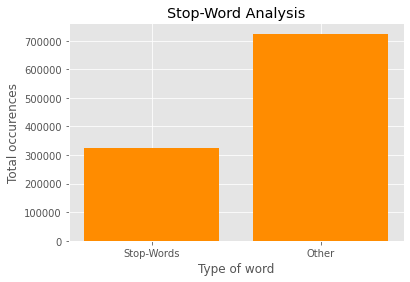

In [103]:
#Plot for Stop-Words in our corpus
def swAnalysis(dataset):
  cnt = 0
  sw = set(stopwords.words('english'))
  for x in dataset["Word"]:
    if x in sw:
      cnt += 1

  data = {'Stop-Words':cnt, 'Other':len(dataset) - cnt} 
  fields = list(data.keys()) 
  values = list(data.values()) 
    
  # fig = plt.figure(figsize = (6, 3)) 
    
  # creating the bar plot 
  plt.bar(fields, values, color ='darkorange') 
    
  plt.xlabel("Type of word") 
  plt.ylabel("Total occurences") 
  plt.title("Stop-Word Analysis") 
  plt.show() 

swAnalysis(data)

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64


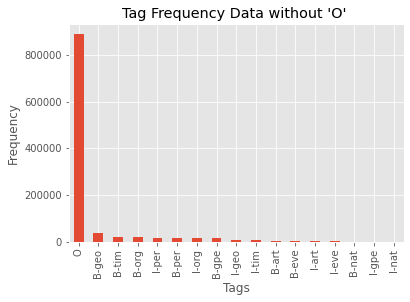

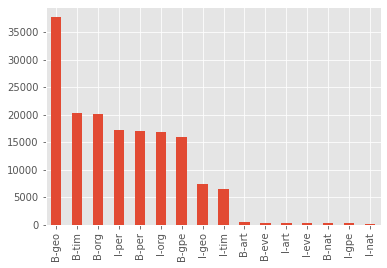

In [5]:
#Distribution of Tags

fig, ax = plt.subplots()
plt.title("Tag Frequency Data without 'O' ")
plt.xlabel("Tags")
plt.ylabel("Frequency")
print(data['Tag'].value_counts())
df = data['Tag'].value_counts()

df.plot(ax=ax, kind='bar')
plt.show()  columns = ["Sentence #", "Word", "POS", "Tag"]
  df2 = df2[columns]
fig, ax = plt.subplots()

df = data['Tag'].value_counts().drop('O')
df.plot(ax=ax, kind='bar')
plt.show()

In [6]:
#Analysis of Dataset

print("Total unique words in corpus :", len(data["Word"].unique()))
print("Total unique entities in our dataset :", len(data["Tag"].unique()))

Total unique words in corpus : 35178
Total unique entities in our dataset : 17


In [7]:
#Getting all unique words
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [8]:
#Getting all unique tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [30]:
print(tags)

['B-per', 'O', 'B-tim', 'B-org', 'I-geo', 'I-tim', 'B-geo', 'I-eve', 'I-org', 'I-art', 'B-nat', 'B-eve', 'I-per', 'I-gpe', 'B-art', 'I-nat', 'B-gpe']


In [9]:
print(num_words, num_tags)

35179 17


In [10]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [11]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [12]:
#Retrieving a sentence
sentences[0:5]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

## **Defining mapping between Words and Tags**

In [13]:
#Defining mapping between sentences and tags
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [14]:
tag2idx

{'B-art': 14,
 'B-eve': 11,
 'B-geo': 6,
 'B-gpe': 16,
 'B-nat': 10,
 'B-org': 3,
 'B-per': 0,
 'B-tim': 2,
 'I-art': 9,
 'I-eve': 7,
 'I-geo': 4,
 'I-gpe': 13,
 'I-nat': 15,
 'I-org': 8,
 'I-per': 12,
 'I-tim': 5,
 'O': 1}

## **Padding Input Sentences**

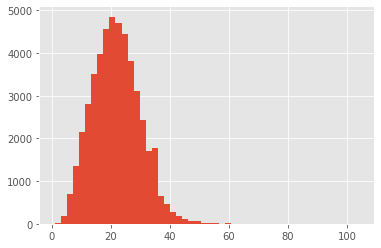

In [15]:
#Padding Input sentences as our input size i.e sentence length is variable.
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [16]:
#From above plot it can be seen that a maximum padding length of 60 is a safe bet.
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [17]:
#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## **Building and Compiling BI_LSTM**

In [18]:
input_word = Input(shape = (max_len))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = "softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


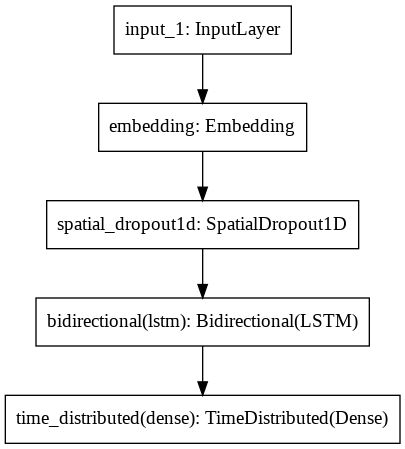

In [19]:
plot_model(model)

In [20]:
#For this project, we will be using the adam optimizer which is combination of gradient descent with momentum and RMS Prop.
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", get_f1, precision_m, recall_m])

# **Training the Model**

In [ ]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 1, verbose = 0, mode = "max")
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 6,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/6
  66/1080 [>.............................] - ETA: 3:18 - loss: 0.0120 - accuracy: 0.9961 - get_f1: 0.9961 - precision_m: 0.9965 - recall_m: 0.9957

# **Evaluation**

In [22]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 4s 26ms/step - loss: 0.0519 - accuracy: 0.9856 - get_f1: 0.9860 - precision_m: 0.9874 - recall_m: 0.9845


[0.051905833184719086,
 0.9856088161468506,
 0.9859773516654968,
 0.9874256253242493,
 0.9845336675643921]

In [ ]:
i = 5
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
print(p)

y_true = np.argmax(np.array(y_test), axis = -1)[i]
print(y_true)
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))

print("-"*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

In [ ]:
print(y_test[1])
y_true = np.argmax(np.array(y_test), axis = -1)[1]
y_true

# **Some Experimentation**

In [80]:
def plotMetrics(model):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def run(currDF):
  wordsx = list(set(currDF["Word"].values))
  wordsx.append("ENDPAD")
  num_words = len(wordsx)
  tags = list(set(currDF["Tag"].values))
  num_tags = len(tags)

  getter = SentenceGetter(currDF)
  sents = getter.sentences
  word2idx = {w: i+1 for i, w in enumerate(wordsx)}
  tag2idx = {t: i for i, t in enumerate(tags)}
  max_len = 60

  X = [[word2idx[w[0]] for w in s] for s in sents]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

  y = [[tag2idx[w[2]] for w in s] for s in sents]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  y = [to_categorical(i, num_classes = num_tags) for i in y]

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

  input_word = Input(shape = (max_len))
  model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
  model = SpatialDropout1D(0.1)(model)
  model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
  out = TimeDistributed(Dense(num_tags, activation = "softmax"))(model)
  model = Model(input_word, out)
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", get_f1, precision_m, recall_m])

  #early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 1, verbose = 0, mode = "max")
  #early_stopping = EarlyStopping(monitor = "val_accuracy", verbose = 0, mode = "max")
  
  callbacks = [PlotLossesCallback()]

  history = model.fit(
      x_train, np.array(y_train),
      validation_split = 0.2,
      batch_size = 32,
      epochs = 10,
      verbose = 1,
      callbacks = callbacks
  )

  return history

In [75]:
datasw = removeStopWords(data[0: int(len(data)/10)])
print(datasw.head())
print(len(datasw))

    Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1  Sentence: 1  demonstrators  NNS      O
2  Sentence: 1        marched  VBN      O
3  Sentence: 1         London  NNP  B-geo
4  Sentence: 1        protest   VB      O
72231


In [76]:
dataO = removeO(data[0: int(len(data)/10)])

dataO = dataO.append({"Sentence #" : "Sentence: 47959", "Word" : "marched", "POS" : "VPN", "Tag" : "O"}, ignore_index = True)
print(dataO)
print(len(dataO))

            Sentence #      Word  POS    Tag
0          Sentence: 1    London  NNP  B-geo
1          Sentence: 1      Iraq  NNP  B-geo
2          Sentence: 1   British   JJ  B-gpe
3          Sentence: 2      Bush  NNP  B-per
4          Sentence: 3      Hyde  NNP  B-geo
...                ...       ...  ...    ...
16019   Sentence: 4766  Espersen  NNP  B-per
16020   Sentence: 4766   Denmark  NNP  B-geo
16021   Sentence: 4768    August  NNP  B-tim
16022   Sentence: 4768      Dane   NN  B-gpe
16023  Sentence: 47959   marched  VPN      O

[16024 rows x 4 columns]
16024


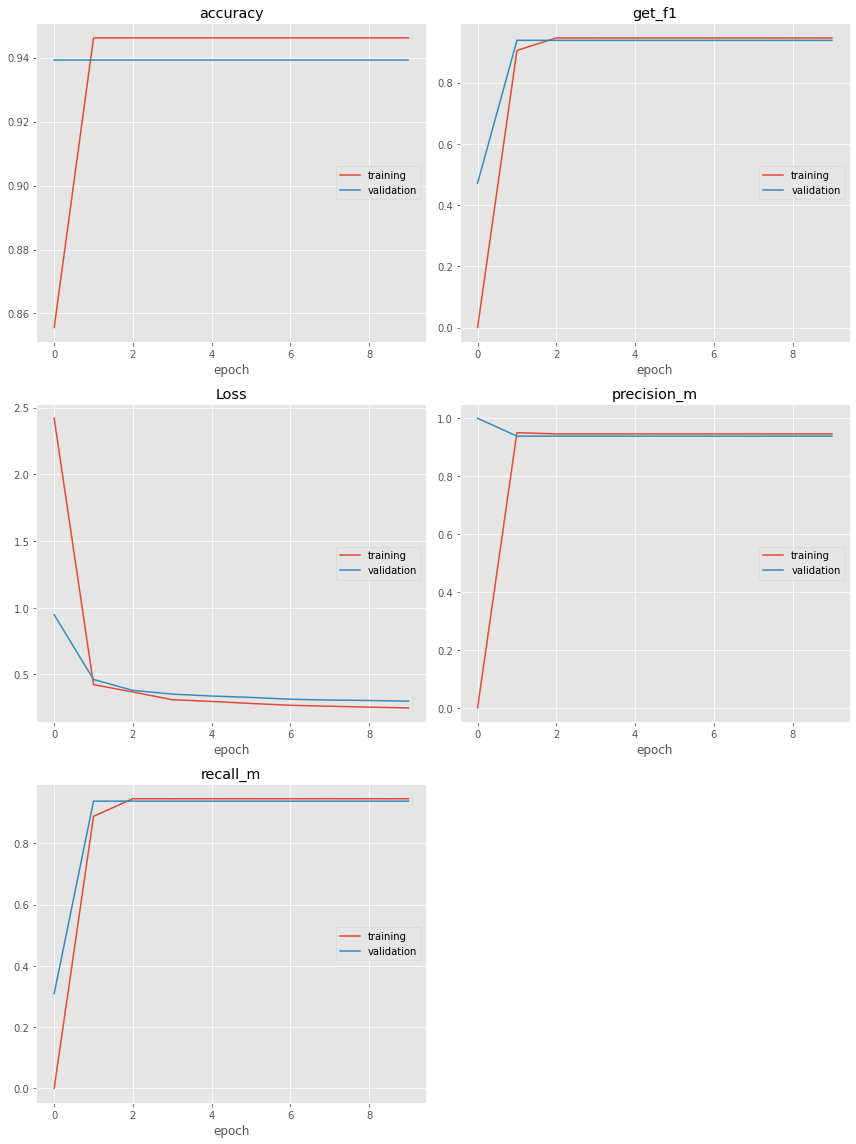

accuracy
	training         	 (min:    0.856, max:    0.946, cur:    0.946)
	validation       	 (min:    0.939, max:    0.939, cur:    0.939)
get_f1
	training         	 (min:    0.000, max:    0.946, cur:    0.946)
	validation       	 (min:    0.472, max:    0.938, cur:    0.938)
Loss
	training         	 (min:    0.249, max:    2.420, cur:    0.249)
	validation       	 (min:    0.300, max:    0.948, cur:    0.300)
precision_m
	training         	 (min:    0.000, max:    0.950, cur:    0.946)
	validation       	 (min:    0.938, max:    1.000, cur:    0.938)
recall_m
	training         	 (min:    0.000, max:    0.946, cur:    0.946)
	validation       	 (min:    0.309, max:    0.938, cur:    0.938)
11/11 [==============================] - 3s 289ms/step - loss: 0.2491 - accuracy: 0.9462 - get_f1: 0.9462 - precision_m: 0.9462 - recall_m: 0.9462 - val_loss: 0.2997 - val_accuracy: 0.9393 - val_get_f1: 0.9384 - val_precision_m: 0.9384 - val_recall_m: 0.9384


In [108]:
run(data[0: int(len(data)/10)])

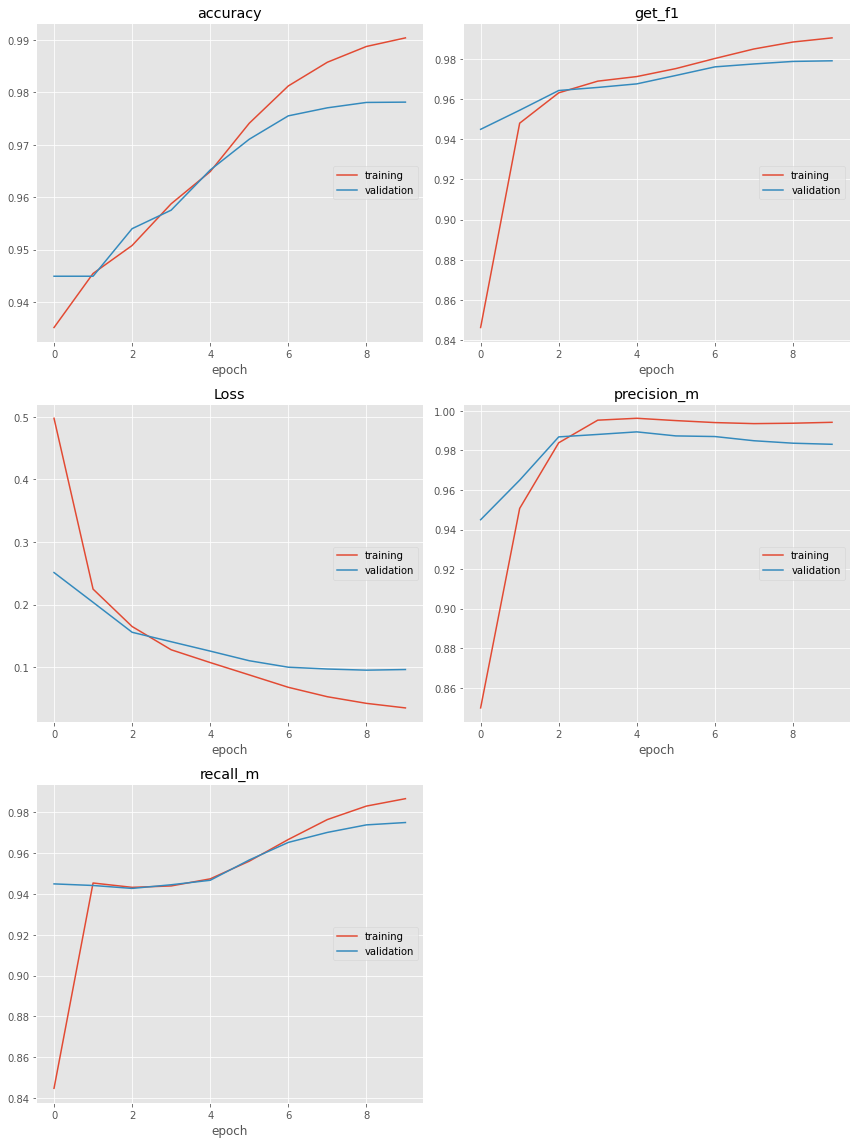

accuracy
	training         	 (min:    0.935, max:    0.990, cur:    0.990)
	validation       	 (min:    0.945, max:    0.978, cur:    0.978)
get_f1
	training         	 (min:    0.846, max:    0.990, cur:    0.990)
	validation       	 (min:    0.945, max:    0.979, cur:    0.979)
Loss
	training         	 (min:    0.035, max:    0.498, cur:    0.035)
	validation       	 (min:    0.095, max:    0.251, cur:    0.096)
precision_m
	training         	 (min:    0.850, max:    0.996, cur:    0.994)
	validation       	 (min:    0.945, max:    0.989, cur:    0.983)
recall_m
	training         	 (min:    0.845, max:    0.987, cur:    0.987)
	validation       	 (min:    0.943, max:    0.975, cur:    0.975)
108/108 [==============================] - 25s 232ms/step - loss: 0.0348 - accuracy: 0.9904 - get_f1: 0.9905 - precision_m: 0.9942 - recall_m: 0.9867 - val_loss: 0.0962 - val_accuracy: 0.9782 - val_get_f1: 0.9791 - val_precision_m: 0.9831 - val_recall_m: 0.9750


In [82]:
run(datasw)

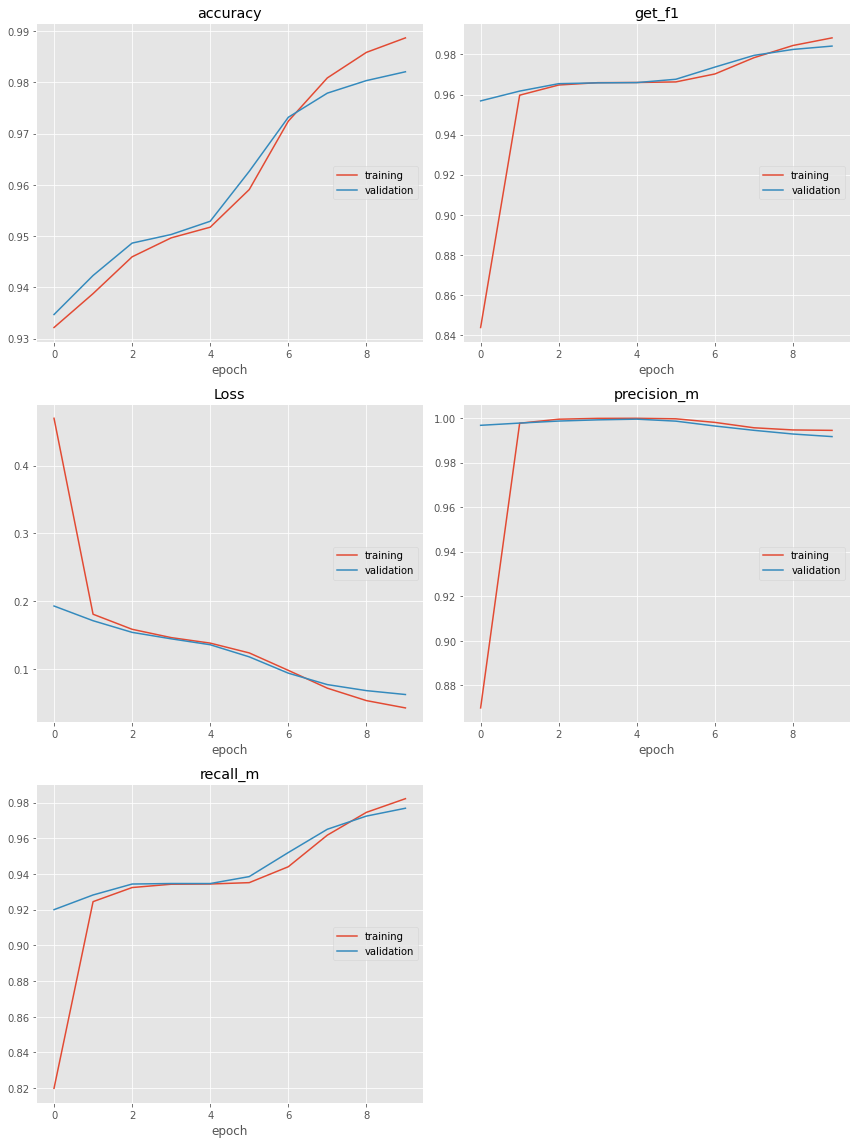

accuracy
	training         	 (min:    0.932, max:    0.989, cur:    0.989)
	validation       	 (min:    0.935, max:    0.982, cur:    0.982)
get_f1
	training         	 (min:    0.844, max:    0.988, cur:    0.988)
	validation       	 (min:    0.957, max:    0.984, cur:    0.984)
Loss
	training         	 (min:    0.043, max:    0.470, cur:    0.043)
	validation       	 (min:    0.063, max:    0.193, cur:    0.063)
precision_m
	training         	 (min:    0.870, max:    1.000, cur:    0.994)
	validation       	 (min:    0.992, max:    0.999, cur:    0.992)
recall_m
	training         	 (min:    0.820, max:    0.982, cur:    0.982)
	validation       	 (min:    0.920, max:    0.977, cur:    0.977)
92/92 [==============================] - 22s 242ms/step - loss: 0.0428 - accuracy: 0.9887 - get_f1: 0.9883 - precision_m: 0.9945 - recall_m: 0.9822 - val_loss: 0.0626 - val_accuracy: 0.9821 - val_get_f1: 0.9842 - val_precision_m: 0.9917 - val_recall_m: 0.9768


In [83]:
run(dataO)